In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf

# audio features
import librosa
import librosa.display

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
CSV_PATH = Path("../../data/processed/icbhi/icbhi_segments.csv")
WAV_DIR  = Path("../../data/processed/icbhi/audio_4000hz_bp_segments")

print("CSV_PATH:", CSV_PATH.resolve())
print("WAV_DIR :", WAV_DIR.resolve())
print("WAV_DIR exists:", WAV_DIR.exists())

CSV_PATH: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\icbhi\icbhi_segments.csv
WAV_DIR : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\icbhi\audio_4000hz_bp_segments
WAV_DIR exists: True


In [3]:
segments_df = pd.read_csv(CSV_PATH)

# expected segment filename from record_id + segment_index
segments_df["segment_wav"] = segments_df.apply(
    lambda r: f"{r['record_id']}_seg{int(r['segment_index']):03d}.wav", axis=1
)
segments_df["wav_path"] = segments_df["segment_wav"].apply(lambda x: str(WAV_DIR / x))

print("Rows:", len(segments_df))
display(segments_df.head())

Rows: 17934


,record_id,file_name,segment_index,seg_start_sec,seg_end_sec,seg_duration_sec,acoustic_label,frac_normal,frac_wheeze,frac_crackle,frac_crackle_wheeze,patient_id,diagnosis,chest_location,segment_wav,wav_path
0,101_1b1_Al_sc_Meditron,101_1b1_Al_sc_Meditron.wav,0,0.0,2.5,2.5,normal,0.986,0.0,0.0,0.0,101,URTI,Al,101_1b1_Al_sc_Meditron_seg000.wav,..\..\data\processed\icbhi\audio_4000hz_bp_seg...
1,101_1b1_Al_sc_Meditron,101_1b1_Al_sc_Meditron.wav,1,1.0,3.5,2.5,normal,1.000,0.0,0.0,0.0,101,URTI,Al,101_1b1_Al_sc_Meditron_seg001.wav,..\..\data\processed\icbhi\audio_4000hz_bp_seg...
2,101_1b1_Al_sc_Meditron,101_1b1_Al_sc_Meditron.wav,2,2.0,4.5,2.5,normal,1.000,0.0,0.0,0.0,101,URTI,Al,101_1b1_Al_sc_Meditron_seg002.wav,..\..\data\processed\icbhi\audio_4000hz_bp_seg...
3,101_1b1_Al_sc_Meditron,101_1b1_Al_sc_Meditron.wav,3,3.0,5.5,2.5,normal,1.000,0.0,0.0,0.0,101,URTI,Al,101_1b1_Al_sc_Meditron_seg003.wav,..\..\data\processed\icbhi\audio_4000hz_bp_seg...
4,101_1b1_Al_sc_Meditron,101_1b1_Al_sc_Meditron.wav,4,4.0,6.5,2.5,normal,1.000,0.0,0.0,0.0,101,URTI,Al,101_1b1_Al_sc_Meditron_seg004.wav,..\..\data\processed\icbhi\audio_4000hz_bp_seg...


In [4]:
exists_mask = segments_df["wav_path"].apply(lambda p: Path(p).exists())
missing = segments_df.loc[~exists_mask, ["record_id", "segment_index", "wav_path"]]

print("Missing wavs:", len(missing))
if len(missing):
    display(missing.head(50))


Missing wavs: 0


In [5]:
# neem 1 voorbeeld (of kies zelf een index)
row = segments_df.sample(1, random_state=42).iloc[0]
wav_path = row["wav_path"]

y, sr = sf.read(wav_path, dtype="float32")
print("Example:", wav_path)
print("y shape:", y.shape, "| sr:", sr, "| duration:", len(y)/sr, "sec")


Example: ..\..\data\processed\icbhi\audio_4000hz_bp_segments\178_1b2_Pl_mc_AKGC417L_seg012.wav
y shape: (10000,) | sr: 4000 | duration: 2.5 sec


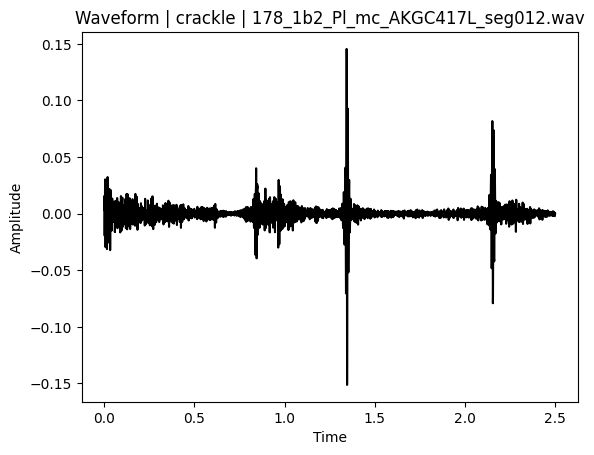

In [33]:
plt.figure()
time = np.arange(len(y)) / sr
plt.plot(time, y, color="k")
plt.title(f"Waveform | {row['acoustic_label']} | {Path(wav_path).name}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


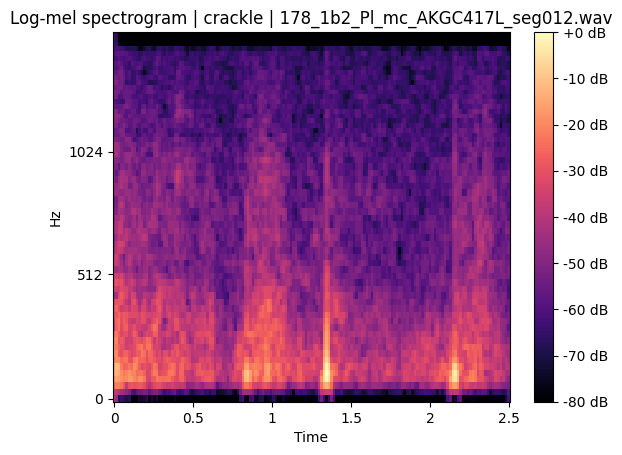

In [7]:
# log-mel params (baseline; later tunen in experiments)
n_fft = 256
hop_length = 64
n_mels = 64
fmin = 20
fmax = sr / 2

S = librosa.feature.melspectrogram(
    y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
    n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0
)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure()
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Log-mel spectrogram | {row['acoustic_label']} | {Path(wav_path).name}")
plt.show()


In [12]:
# normaliseer labels (voor het geval er hoofdletters/spaties bestaan)
segments_df["acoustic_label"] = segments_df["acoustic_label"].astype(str).str.strip().str.lower()

# verwachte set
valid = {"normal", "crackle", "wheeze", "mixed"}
bad = sorted(set(segments_df["acoustic_label"]) - valid)
print("Rows after dropping unexpected labels:", len(segments_df))
print("Unexpected labels:", bad)

# drop reject
segments_df = segments_df[segments_df["acoustic_label"].isin(valid)].copy()
print("Rows after dropping unexpected labels:", len(segments_df))


Rows after dropping unexpected labels: 17934
Unexpected labels: ['reject']
Rows after dropping unexpected labels: 15465


In [13]:
# encode labels -> one-hot
le = LabelEncoder()
y_int = le.fit_transform(segments_df["acoustic_label"])
y_onehot = keras.utils.to_categorical(y_int, num_classes=len(le.classes_))

print("Classes:", list(le.classes_))


Classes: ['crackle', 'mixed', 'normal', 'wheeze']


In [14]:
def logmel_01_from_wav(path, n_fft=256, hop_length=64, n_mels=64, fmin=20):
    y, sr = sf.read(path, dtype="float32")
    fmax = sr / 2

    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0
    )
    S_db = librosa.power_to_db(S, ref=np.max)

    # min-max -> [0,1] per segment
    mn, mx = S_db.min(), S_db.max()
    X = (S_db - mn) / (mx - mn + 1e-8)

    # channel dim
    X = X.astype(np.float32)[..., np.newaxis]  # (n_mels, n_frames, 1)
    return X


In [15]:
# build X for all segments (baseline; later kun je dit met tf.data doen)
X_list = []
for p in segments_df["wav_path"].tolist():
    X_list.append(logmel_01_from_wav(p, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=fmin))

X = np.stack(X_list, axis=0)
print("X shape:", X.shape)  # (N, n_mels, n_frames, 1)


X shape: (15465, 64, 157, 1)


In [16]:
patients = segments_df["patient_id"].astype(str).values
unique_patients = np.unique(patients)

train_p, val_p = train_test_split(unique_patients, test_size=0.2, random_state=42, shuffle=True)

train_mask = np.isin(patients, train_p)
val_mask   = np.isin(patients, val_p)

X_train, X_val = X[train_mask], X[val_mask]
y_train, y_val = y_onehot[train_mask], y_onehot[val_mask]

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)


Train: (11370, 64, 157, 1) (11370, 4)
Val  : (4095, 64, 157, 1) (4095, 4)


In [17]:
input_shape = X_train.shape[1:]  # (n_mels, n_frames, 1)
num_classes = y_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, kernel_size=(4,2), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    layers.Conv2D(64, kernel_size=(4,2), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    layers.Conv2D(128, kernel_size=(4,2), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    layers.Conv2D(256, kernel_size=(4,2), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2,2), strides=(1,2)),  # keep more temporal resolution

    layers.Flatten(),

    layers.Dense(2000, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 157, 32)    │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 78, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 39, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 19, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 19, 256)     │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2000)           │    32,258,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         8,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,610,804 (124.40 MB)

 Trainable params: 32,610,804 (124.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early],
    verbose=1
)


Epoch 1/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 61s 167ms/step - accuracy: 0.5201 - loss: 1.1573 - val_accuracy: 0.4357 - val_loss: 1.2554
Epoch 2/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.5205 - loss: 1.1325 - val_accuracy: 0.4320 - val_loss: 1.2649
Epoch 3/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 52s 145ms/step - accuracy: 0.5253 - loss: 1.1008 - val_accuracy: 0.4342 - val_loss: 1.2799
Epoch 4/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 52s 146ms/step - accuracy: 0.5418 - loss: 1.0520 - val_accuracy: 0.4300 - val_loss: 1.2600
Epoch 5/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 53s 149ms/step - accuracy: 0.5754 - loss: 0.9959 - val_accuracy: 0.4459 - val_loss: 1.3858
Epoch 6/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 54s 151ms/step - accuracy: 0.6070 - loss: 0.9349 - val_accuracy: 0.4344 - val_loss: 1.4026


In [19]:
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print("Val loss:", val_loss)
print("Val acc :", val_acc)


Val loss: 1.2553761005401611
Val acc : 0.4356532394886017


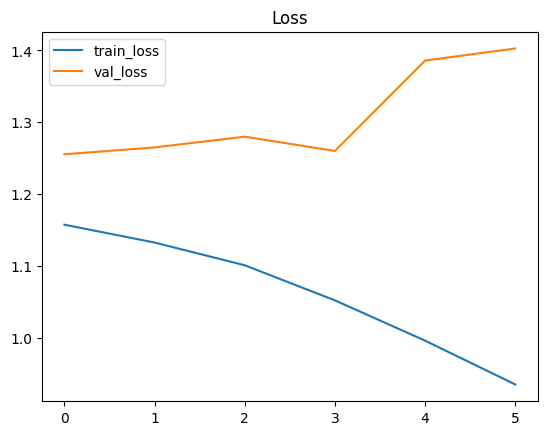

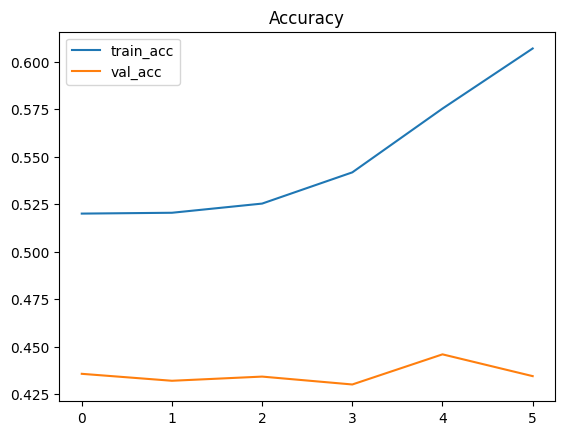

In [20]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()


In [29]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 157, 32)    │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 78, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 39, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 19, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 19, 256)     │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2000)           │    32,258,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         8,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,610,804 (124.40 MB)

 Trainable params: 32,610,804 (124.40 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# y_int heb je al (LabelEncoder output), maak train/val indices opnieuw consistent
# We bouwen y_int_train/y_int_val op basis van dezelfde masks die je eerder gebruikte.
y_int_train = y_int[train_mask]
y_int_val   = y_int[val_mask]

In [31]:
# class weights (balanced)
classes = np.unique(y_int_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_int_train)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}

print("Classes:", list(le.classes_))
print("Class counts (train):", {int(c): int((y_int_train == c).sum()) for c in classes})
print("Class weights:", class_weight)

Classes: ['crackle', 'mixed', 'normal', 'wheeze']
Class counts (train): {0: 2845, 1: 1291, 2: 5943, 3: 1291}
Class weights: {0: 0.9991212653778558, 1: 2.201781564678544, 2: 0.4782937910146391, 3: 2.201781564678544}


In [32]:
# Early stopping (optioneel, maar nuttig)
early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Nieuwe training met class weights
history_w = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[early],
    verbose=1
)

Epoch 1/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 130s 364ms/step - accuracy: 0.3478 - loss: 1.3039 - val_accuracy: 0.3013 - val_loss: 1.4459
Epoch 2/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 218s 615ms/step - accuracy: 0.3886 - loss: 1.2430 - val_accuracy: 0.3592 - val_loss: 1.3405
Epoch 3/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.4361 - loss: 1.1756 - val_accuracy: 0.3455 - val_loss: 1.4507
Epoch 4/10
242/356 ━━━━━━━━━━━━━━━━━━━━ 55s 489ms/step - accuracy: 0.4793 - loss: 1.1198

KeyboardInterrupt: 

In [ ]:
# Evaluatie
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print("Val loss:", val_loss)
print("Val acc :", val_acc)

In [ ]:
plt.figure()
plt.plot(history_w.history["loss"], label="train_loss")
plt.plot(history_w.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(history_w.history["accuracy"], label="train_acc")
plt.plot(history_w.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()
